# Read dataset and plot graph

In [1]:
#pip install numpy
#pip install pandas
#pip install pandas-profiling
#pip install networkx
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import json
import networkx as nx
import matplotlib.pyplot as plt
from random import randrange

def read_dataset(path,drop_columns=None,keep_columns=None):
    #get rid of useless columns
    csv_data = pd.read_csv(path)
    
    if keep_columns != None:
        #keep only these columns
        return csv_data.filter(items=keep_columns)
    
    if drop_columns!= None:
        #drop these and keep the rest
        return csv_data.drop(drop_columns, axis=1)
    
    #finally, didn't drop or filter any column
    return csv_data     

def plot_graph(g,ds_nodes=[],attribute_nodes=[],feat_nodes=[],lit_nodes=[]):
    pos=nx.spring_layout(g)    
    nx.draw_networkx_nodes(g,pos,nodelist=ds_nodes,node_color="blue",node_size=900)
    nx.draw_networkx_nodes(g,pos,nodelist=attribute_nodes,node_color="green",node_size=900)
    nx.draw_networkx_nodes(g,pos,nodelist=feat_nodes,node_color="grey",node_size=900)
    nx.draw_networkx_nodes(g,pos,nodelist=lit_nodes,node_color="red",node_size=900)

    nx.draw_networkx_edges(g,pos,width=3)
    nx.draw_networkx_labels(g,pos,font_size=8)
    plt.show() 

## Graph Data_Sets construction

In [2]:
def graph_dataset(datasets,instances=0):
    g = nx.Graph()
    #create nodes and edges at datasetLevel
    features = datasets.columns[1:]
    ds_nodes = []
    feat_nodes = []
    lit_nodes = []
    
    if instances==0:
        number_instances = len(datasets)
    else:
        number_instances = instances
    
    for r in range(number_instances): 
        #node id is the openML id which is in the first column
        node_id = "DS_"+str(datasets.iloc[r][0])
        row = datasets.iloc[r][1:]
        
        if instances == 0:
            number_features = len(features)
        else:
            number_features = min(instances,len(features))
            
        for i in range (number_features):
            feature_dataset = features[i]+"_"+node_id
            g.add_edge(node_id,feature_dataset)
            g.add_edge(feature_dataset,row[i])
            ds_nodes.append(node_id)
            feat_nodes.append(feature_dataset)
            lit_nodes.append(row[i])
            
    return g,ds_nodes,feat_nodes,lit_nodes

## Graph Attribute construction

In [3]:
def graph_attribute(datasets,instances=0,graph=None,ds_nodes=None,feat_nodes=None,lit_nodes=None,attr_nodes=None):
    if graph == None:
        g = nx.Graph()
    else:
        g = graph
        
    #create nodes and edges at datasetLevel
    features = datasets.columns[2:]
    if ds_nodes == None:
        ds_nodes = []
    if feat_nodes == None:
        feat_nodes = []
    if lit_nodes == None:
        lit_nodes = []
    if attr_nodes == None:
        attr_nodes = []
    
    if instances==0:
        number_instances = len(datasets)
    else:
        number_instances = min (instances,len(datasets))
    
    for r in range(number_instances): 
        #node id is the openML id which is in the first column
        #attr name is the 2nd column
        node_dataset_id = "DS_"+str(datasets.iloc[r][0])
        node_attribute_id = datasets.iloc[r][1] + "_"+node_dataset_id
        row = datasets.iloc[r][2:]
        
        
        #relation of dataset and an attribute
        g.add_edge(node_dataset_id,node_attribute_id)
        
        ds_nodes.append(node_dataset_id)
        attr_nodes.append(node_attribute_id)
        
        
        if instances == 0:
            number_features = len(features)
        else:
            number_features = min (instances,len(features))
            
        for i in range (number_features):
            feature_attribute = features[i]+"_"+str(node_attribute_id)
            g.add_edge(node_attribute_id,feature_attribute)
            g.add_edge(feature_attribute,row[i])
            feat_nodes.append(feature_attribute)
            lit_nodes.append(row[i])
            
    return g,ds_nodes,attr_nodes,feat_nodes,lit_nodes

# Test

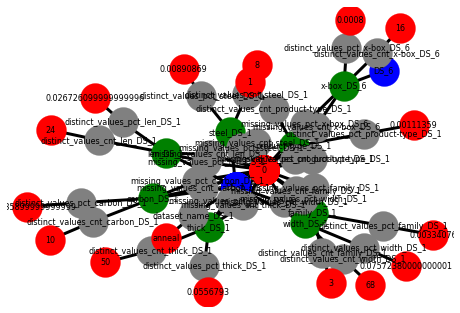

In [4]:
df_dataset = read_dataset("./openml_203ds_datasets_index.csv",drop_columns=["Num", "dataset_topic"]);
g,ds_nodes,feat_nodes,lit_nodes=graph_dataset(df_dataset,instances=1);
df_attributes = read_dataset("./openml_203ds_attributes_nominal_index.csv",drop_columns=["dataset_name", "type_converted"]);
g,ds_nodes,attr_nodes,feat_nodes,lit_nodes = graph_attribute(df_attributes,4,g,ds_nodes,feat_nodes,lit_nodes)
df_attributes_numeric = read_dataset("./openml_203ds_attributes_numeric_index.csv",drop_columns=["dataset_name", "type_converted"]);
g,ds_nodes,attr_nodes,feat_nodes,lit_nodes = graph_attribute(df_attributes_numeric,4,g,ds_nodes,feat_nodes,lit_nodes,attr_nodes)
plot_graph(g,ds_nodes,attr_nodes,feat_nodes,lit_nodes);



## Possitive and negative samples

In [5]:
def get_samples(df):
    possitive_pairs = []
    negative_pairs = []
    for index, row in df.iterrows():
        if row[2] == 1:
            possitive_pairs.append((row[0],row[1]))
        else:
            if randrange(1, 10) > 8:
                negative_pairs.append((row[0],row[1]))
    return possitive_pairs,negative_pairs

In [6]:
df_matching = read_dataset("./openml_203ds_datasets_matching.csv",keep_columns=["'dataset1_id'", "'dataset2_id'","'matching_topic'"]);
pos,neg = get_samples(df_matching)
print("Possitive samples: "+str(len(pos)) + " Negative samples (10%): "+str(len(neg)))


Possitive samples: 543 Negative samples (10%): 2166


## Convert strings to single words

In [7]:
def is_number(s):
    """ Returns True is string is a number. """
    try:
        float(s)
        return True
    except ValueError:
        return False

In [8]:
def get_tokens(nodes):
    nodes_unique = set(nodes)
    numerical=[]
    nominal=[]
    for s in nodes_unique:
        if is_number(s):
            numerical.append(float(s))
        else:
            nominal = nominal +  list(map(lambda a : re.sub(r'[^A-Za-z0-9 ]+', '', a).lower(),(re.split('[-_;|]\s*',s))))
            #nominal = nominal +  s.split("|")
    return list(set(numerical)),list(set(nominal))

## cosine similarity

In [10]:
from scipy.spatial.distance import cosine
def cosine_vectors(vec1,vec2):
    return (1- cosine(vec1,vec2))

## Fasttext

In [12]:
#pip install fasttext
import fasttext
#fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('../models/cc.en.300.bin')
print(ft.get_dimension())

300


In [23]:
def fasttex_vectors(nodes_literals):
    nodes_vector = []
    for literal in nodes_literals:
        
        if is_number(literal):
            literal = str(literal)
        
        nodes_vector.append(ft.get_sentence_vector(literal))
        
    return nodes_vector

## Bert


In [14]:
#pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
#pip install transformers
from transformers import BertModel, BertTokenizer
import torch

#load model in memory
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-12_H-768_A-12')
model = BertModel.from_pretrained('google/bert_uncased_L-12_H-768_A-12')
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = BertModel.from_pretrained('bert-base-uncased')
# This is IMPORTANT to have reproducible results during evaluation!
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [15]:
def bert_vectors(nodes_literals):
    nodes_vector = []
    for literal in nodes_literals:
        
        if is_number(literal):
            literal = str(literal)
        
        #add special tokens at the begining and end, and takes until 512 tokens max 
        tokenized = tokenizer.encode(literal, add_special_tokens=True,max_length=512)
        input_ids = torch.tensor(tokenized).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids)

        last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple
        #result shape: (batch size, sequence length, model hidden dimension)
        #print(last_hidden_states.shape)
        
        #make the mean of the vectors to have 1 vector for the whole sentence and store result
        nodes_vector.append(torch.mean(last_hidden_states[0],dim=0).detach()) 
    return nodes_vector

## Get embeddings of words and calculate similarity

In [27]:
s1= "University degree"
s2="Bachelor"
vectors_b = bert_vectors([s1,s2])
vectors_ft = fasttex_vectors([s1,s2])
print("Fasttext dif: " + str(cosine_vectors(vectors_ft[0],vectors_ft[1])))
print("Bert dif: " + str(cosine_vectors(vectors_b[0],vectors_b[1])))

Fasttext dif: 0.520315945148468
Bert dif: 0.7249993681907654


In [28]:
from decimal import Decimal
rep = '%.4E' % Decimal(88799777378)
print(rep)

8.8800E+10


In [ ]:
df = pd.DataFrame(vectors, columns=["colummn"])
df.to_csv('lit_vectors.csv', index=False)

In [11]:
len(lit_nodes)

33